# 3D Lagrange Polynomial Interpolation from a Uniform Numerical Grid

## Author: Zachariah Etienne

## This module implements a start-to-finish C code for performing Lagrange polynomial interpolation within a uniform 3D numerical grid

<font color='green'>**This module demonstrates convergence to zero of interpolation errors at the expected convergence rates for 3D Lagrange polynomial interpolation**</font>

<a id='toc'></a>

# Table of Contents:  
$$\label{toc}$$

1. [Step 1](#ccode): Implement a complete C code for generic 3D interpolation testing
1. [Step 2](#bench): Benchmark results
1. [Step 3](#conv): Convergence testing
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='step1'></a>

# Step 1: Implement a complete C code for generic 3D interpolation testing \[Back to [top](#toc)\]
$$\label{step1}$$

<a id='cparams_rfm_and_domainsize'></a>

## Step 1.a: Output C codes needed for declaring and setting Cparameters; also set `free_parameters.h` \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

Based on declared NRPy+ Cparameters, first we generate `declare_Cparameters_struct.h`, `set_Cparameters_default.h`, and `set_Cparameters[-SIMD].h`.

Then we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above

In [1]:
# Step 1: Import needed NRPy+ core modules:
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import shutil, os                # Standard Python modules for multiplatform OS-level functions
import interpolation.interpolate_Ccodegen_library as interpClib # Interpolation C codegen library
from outputC import outC_function_prototype_dict, add_to_Cfunction_dict, construct_Makefile_from_outC_function_dict

# Step 2: Create C code output directory:
Ccodesrootdir = os.path.join("Lag3D_Interpolation_Ccodes")
# First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(os.path.join(Ccodesrootdir))

# Step 3: Set up parameters used in C codes including numerical grid parameters:
#         store in set_Nxx_dxx_invdx_params__and__xx.h, *Cparameters*.h, and free_parameters.h files.
# Step 3.a: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesrootdir))

# Step 3.b: Set free_parameters.h
domain_size = 1.0 # For the purposes of this start-to-finish module, let's
                  #   set Cartesian coordinates in a unit cube.
CoordSystem="Cartesian" # Any coordinate system (with uniform grids) is supported;
                        # however, let's stick with Cartesian coordinates.
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)
rfm.reference_metric() # Create ReU, ReDD needed for rescaling B-L initial data, generating BSSN RHSs, etc.

# Step 3.c: Append to $Ccodesrootdir/free_parameters.h reference metric
#           parameters based on generic domain_size parameter set above.
rfm.out_default_free_parameters_for_rfm(os.path.join(Ccodesrootdir,"free_parameters.h"),domain_size)
#                                         EvolveType="none")

# Step 3.d: Generate set_Nxx_dxx_invdx_params__and__xx(const int EigenCoord, const int Nxx[3],
#                                       paramstruct *restrict params, REAL *restrict xx[3]),
#          which sets params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for
#          the chosen Eigen-CoordSystem if EigenCoord==1, or
#          CoordSystem if EigenCoord==0.
rfm.add_to_Cfunc_dict_set_Nxx_dxx_invdx_params__and__xx(NGHOSTS_is_a_param=True)

# Step 3.e: Set NGHOSTS as a parameter here so we can set it at the command line.
NGHOSTSignore = par.Cparameters("int", "standalonecode", ["NGHOSTS"], 4)

# Step 3.e: Generate declare_Cparameters_struct.h, set_Cparameters_default.h, and set_Cparameters[-SIMD].h
par.generate_Cparameters_Ccodes(os.path.join(Ccodesrootdir))

# Step 4: Add core interpolation functions to Cfunction_dict:
inlined_functions  = interpClib.codegen_Lagrange_interp_coeffs_3D()
inlined_functions += interpClib.codegen_Lagrange_sum_3D()
inlined_functions += interpClib.codegen_construct_x0i_x1j_x2k_stencil_arrays_3D()
interpClib.add_uniform_Lagrange_interp_3D_to_Cfunction_dict(prefunc = inlined_functions + "\n\n")

# Step 5: Create function prototypes for all functions in the Cfunction_dict
with open(os.path.join(Ccodesrootdir, "NRPy_functions.h"), "w") as file:
    for key, item in outC_function_prototype_dict.items():
        file.write(item + "\n")

# Step 6: Create NRPy_basic_defines.h, which defines REAL & IDX4S() macros:
with open(os.path.join(Ccodesrootdir, "NRPy_basic_defines.h"), "w") as file:
    file.write("""
// Part P1a: set REAL=double, so that all floating point numbers are stored to at least ~16 significant digits.
#define REAL double

// Part P2b: Declare the IDX4(gf,i,j,k) macro, which enables us to store 4-dimensions of
//           data in a 1D array. In this case, consecutive values of "i"
//           (all other indices held to a fixed value) are consecutive in memory, where
//           consecutive values of "j" (fixing all other indices) are separated by
//           Nxx_plus_2NGHOSTS[0] elements in memory. Similarly, consecutive values of
//           "k" are separated by Nxx_plus_2NGHOSTS[0]*Nxx_plus_2NGHOSTS[1] in memory, etc.
#define IDX4S(g,i,j,k) \
( (i) + Nxx_plus_2NGHOSTS0 * ( (j) + Nxx_plus_2NGHOSTS1 * ( (k) + Nxx_plus_2NGHOSTS2 * (g) ) ) )
""")


# Step 7: Set gridfunction_defines.h, which sets the number of gridfunctions, etc.
import grid as gri
uu = gri.register_gridfunctions("AUX", "uu")
g = gri.output__gridfunction_defines_h__return_gf_lists(os.path.join(Ccodesrootdir))

In [2]:
includes = ["NRPy_basic_defines.h", # Defines REAL & IDX3S macros. This header is generated in NRPy+.
            "gridfunction_defines.h", # Defines NUM_*_GFS & gridfunction aliases
            "declare_Cparameters_struct.h", # Defines paramstruct
            "NRPy_functions.h", # Contains NRPy+ function prototypes
            "stdio.h", "stdlib.h", "math.h", "time.h"]  # time.h is for benchmarking

prefunc = r"""
// Pre-main(): Declare the function for the exact solution.
REAL exact_solution(const int exact_soln_type, const REAL xyz[3], const int N0,const int N1,const int N2) {
    const REAL x = xyz[0];
    const REAL y = xyz[1];
    const REAL z = xyz[2];
    //const REAL r = sqrt(x*x + y*y + z*z);
    if(exact_soln_type == 0) {
      return sin(x)*sin(y)*cos(z)+2.0; //(sin(4*x)+cos(3*y)+sin(z))*(-sin(3*z) + sin(4*x)*sin(y));
    } else if(exact_soln_type == 1) {
      return 42.0*pow(x,N0);
    } else if(exact_soln_type == 2) {
      return 42.0*pow(y,N1);
    } else if(exact_soln_type == 3) {
      return 42.0*pow(z,N2);
    } else if(exact_soln_type == 4) {
        REAL sum0 = 0.0,sum1 = 0.0,sum2 = 0.0;
        for(int i=0;i<N0;i++) sum0 += (i+5)*2*pow(x,i);
        for(int j=0;j<N1;j++) sum1 += (j+1)*4*pow(y,j);
        for(int k=0;k<N2;k++) sum2 += (k-2)*1*pow(z,k);
        return sum0*sum1*sum2;
    } else {
      printf("Error exact_soln_type = %d not supported.\n",exact_soln_type);
      exit(1);
    }
}
"""

desc = """main() function:
Step 0.a: Read command-line input, error out if nonconformant
Step 0.b: Set up numerical grid structure
Step 0.c: Allocate memory for gridfunction to be interpolated.
Step 0.d: Set up coordinates: Set dx, and then dt based on dx_min and CFL condition
Step 0.e: Set interpolation constants
Step 0.f: Set up Cartesian coordinate grids
Step 1.a: Specify points to interpolate.
Step 1.b: Set up list of gridfunctions and allocate space for interp_output
Step 2:   Populate numerical grid with exact solution at all grid points.
Step 3:   Interpolate to destination points.
Step 4:   Output relative error between exact & numerical at interpolated points.
Step 5:   Free all allocated memory
"""

type = "int"
name = "main"
params = "int argc, const char *argv[]"
body = r"""
    paramstruct params;
#include "set_Cparameters_default.h"

    int polydegree=-1;
    int num_interp_pts = -1;
    int interp_pts_type = -1;
    int output_type = -1;
    // Step 0.a: Read command-line input, error out if nonconformant
    if(argc == 8) {
        polydegree=atoi(argv[1]);
        if(polydegree%2==0) params.NGHOSTS=polydegree/2;
        else                params.NGHOSTS=polydegree/2+1;
        num_interp_pts  = atoi(argv[2]);
        interp_pts_type = atoi(argv[3]);
        output_type     = atoi(argv[4]);
    } else {
        fprintf(stderr,"Error: Expected 8 command-line arguments:\n");
        fprintf(stderr,"./Lagrange_3D_polynomial_interpolation_lowlevel [poly degree] [num interp pts] [interp pts type] [output type] [Nx] [Ny] [Nz],\n");
        fprintf(stderr,"where Nx, Ny, and Nz is the number of grid points in the x, y, and z directions, respectively.\n");
        exit(1);
    }
    int start_NxNyNz=5;
    if(atoi(argv[start_NxNyNz+0]) < params.NGHOSTS ||
       atoi(argv[start_NxNyNz+1]) < params.NGHOSTS ||
       atoi(argv[start_NxNyNz+2]) < params.NGHOSTS) {
        fprintf(stderr,"Nx, Ny, and Nz MUST BE larger than NGHOSTS (= %d) | (%d %d %d)\n",params.NGHOSTS,
               atoi(argv[start_NxNyNz+0]),atoi(argv[start_NxNyNz+1]),atoi(argv[start_NxNyNz+2]));
        exit(1);
    }
    // Step 0.b: Set up numerical grid structure
    const int Nxx[3] = { atoi(argv[start_NxNyNz]), atoi(argv[start_NxNyNz+1]), atoi(argv[start_NxNyNz+2]) };

    // Step 0c: Set free parameters, overwriting Cparameters defaults
    //          by hand or with command-line input, as desired.
#include "free_parameters.h"
    // Step 0f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    REAL *xx[3];
    int EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &params, xx);

    // Step 0g: Set all C parameters "blah" for params.blah, including
    //          Nxx_plus_2NGHOSTS0 = params.Nxx_plus_2NGHOSTS0, etc.
#include "set_Cparameters-nopointer.h"
    const int Nxx_plus_2NGHOSTS_tot = Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2;

    // Step 0.c: Allocate memory for gridfunction to be interpolated.
    REAL *restrict gfs = (REAL *)malloc(sizeof(REAL) * NUM_AUX_GFS * Nxx_plus_2NGHOSTS_tot);

    // Step 0.e: Set interpolation constants
    const int N0=polydegree,N1=polydegree,N2=polydegree;
    const REAL dx012_term_inv = 1.0 / (pow(dxx0,N0)*pow(dxx1,N1)*pow(dxx2,N2));

    // Step 1.a: Specify points to interpolate.
    REAL *restrict list_of_interp_pts_x0 = (REAL *)malloc(num_interp_pts*sizeof(REAL));
    REAL *restrict list_of_interp_pts_x1 = (REAL *)malloc(num_interp_pts*sizeof(REAL));
    REAL *restrict list_of_interp_pts_x2 = (REAL *)malloc(num_interp_pts*sizeof(REAL));
    srand48(0);
    for(int interp_pt=0;interp_pt<num_interp_pts;interp_pt++) {
        if(interp_pts_type==0) {
            // Points randomly throughout volume
            list_of_interp_pts_x0[interp_pt] = xx[0][NGHOSTS] + drand48()*(xx[0][NGHOSTS+(Nxx[0]-1)]-xx[0][NGHOSTS]);
            list_of_interp_pts_x1[interp_pt] = xx[1][NGHOSTS] + drand48()*(xx[1][NGHOSTS+(Nxx[1]-1)]-xx[1][NGHOSTS]);
            list_of_interp_pts_x2[interp_pt] = xx[2][NGHOSTS] + drand48()*(xx[2][NGHOSTS+(Nxx[2]-1)]-xx[2][NGHOSTS]);
        } else if(interp_pts_type==1) {
            // Points close to x=y=z line
            list_of_interp_pts_x0[interp_pt] = 0.01 + interp_pt*0.9/num_interp_pts; //0.913812712;
            list_of_interp_pts_x1[interp_pt] = 0.01 + interp_pt*0.92/num_interp_pts; //-0.251275219;
            list_of_interp_pts_x2[interp_pt] = 0.01 + interp_pt*0.95/num_interp_pts; //0.1109128512;
        } else if(interp_pts_type==2) {
            // Single point, specified below. if num_interp_pts>1 then this point is set redundantly.
            list_of_interp_pts_x0[interp_pt] = 4.150000e-01;
            list_of_interp_pts_x1[interp_pt] = 4.240000e-01;
            list_of_interp_pts_x2[interp_pt] = 4.375000e-01;
        } else {
            printf("Error: interp_pts_type = %d unsupported!\n",interp_pts_type);
            exit(1);
        }
    }

    // Step 1.b: Set up list of gridfunctions and allocate space for interp_output
    const int num_interp_gfs = 1; int list_of_interp_gfs[num_interp_gfs];
    list_of_interp_gfs[0] = UUGF;
    REAL *restrict interp_output = (REAL *)malloc(num_interp_gfs*num_interp_pts*sizeof(REAL));

    for(int exact_solution_type = 0; exact_solution_type < 1; exact_solution_type++) {
        // Step 2: Populate numerical grid with exact solution at all grid points.
        for(int i0=0;i0<Nxx_plus_2NGHOSTS0;i0++)
            for(int i1=0;i1<Nxx_plus_2NGHOSTS1;i1++)
                for(int i2=0;i2<Nxx_plus_2NGHOSTS2;i2++) {
                    const int idx4 = IDX4S(UUGF,i0,i1,i2);
                    const REAL xyz[3] = { xx[0][i0], xx[1][i1], xx[2][i2] };
                    gfs[idx4] = exact_solution(exact_solution_type,xyz, N0,N1,N2);
                }

        // Start benchmark:
        struct timespec start, end;
        clock_gettime(CLOCK_REALTIME, &start);
        // Step 3: Interpolate to destination points.
        {
            uniform_Lagrange_interp_3D(
                Nxx_plus_2NGHOSTS0,Nxx_plus_2NGHOSTS1,Nxx_plus_2NGHOSTS2,  xx,
                &dx012_term_inv,
                gfs,
                num_interp_gfs,list_of_interp_gfs,
                num_interp_pts,list_of_interp_pts_x0,list_of_interp_pts_x1,list_of_interp_pts_x2,
                N0,N1,N2,
                interp_output);
        }
        // End benchmark:
        clock_gettime(CLOCK_REALTIME, &end);
        const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;

// The following will result in cache misses just below since the innermost loop is
//     over gf, but it ensures consistency with IDX4() in the rest of NRPy+,
//     and ensures quick access with minimal cache misses when accessed from elsewhere.
#define INTERP_IDX(num_interp_pts,gf,pt) ( (pt) + (num_interp_pts) * (gf) )

        // Step 4:  Output relative error between exact & numerical at interpolated points.
        {
            REAL L1norm = 0.0;
            REAL max_error = 0.0;
            for(int re_which_pt=0;re_which_pt <num_interp_pts;re_which_pt++) {
                //const int re_which_pt = num_interp_pts/2;
                const REAL xyz[3] = { list_of_interp_pts_x0[re_which_pt],
                                      list_of_interp_pts_x1[re_which_pt],
                                      list_of_interp_pts_x2[re_which_pt] };
                const REAL numerical = interp_output[INTERP_IDX(num_interp_gfs, UUGF, re_which_pt)];
                const REAL exact     = exact_solution(exact_solution_type,xyz,N0,N1,N2);
                const REAL relative_error = fabs(exact-numerical) / (0.5*(fabs(numerical)+fabs(exact)));
                L1norm += relative_error;
                if(relative_error > max_error) max_error = relative_error;

                if(output_type==0) {
                    printf("%e %e\n",xyz[0],relative_error);
                } else if(output_type==1) {
                    printf("%e %e %e | %e : %.15e %.15e | %.2e s\n",xyz[0],xyz[1],xyz[2],relative_error,numerical,exact, (REAL)(time_in_ns)/1e9);
                } else if(output_type==2) {
                    // Do no additional output other than stderr below.
                } else {
                    if(re_which_pt==num_interp_pts-1)
                        printf("output_type unknown, so not outputting anything.\n");
                }

            }
            fprintf(stderr,"%d %e %e . Interpolated %d points in time: %.6f seconds\n",Nxx[0],max_error,L1norm,num_interp_pts,(REAL)(time_in_ns)/1e9);
        }
    }

    // Step 5: Free all allocated memory
    free(gfs);
    free(interp_output);
    free(list_of_interp_pts_x0);
    free(list_of_interp_pts_x1);
    free(list_of_interp_pts_x2);
    for(int i=0;i<3;i++) free(xx[i]);
    return 0;
"""
add_to_Cfunction_dict(
    prefunc=prefunc,
    includes=includes, desc=desc,
    c_type=type, name=name, params=params,
    body=body, enableCparameters=False)  # Cparameters here must be #include'd in body, not at top of function as usual.

In [3]:
# Options include "fast", "debug", and "fastdebug"
compiler_opt_option = "fast"

###################################
# Finally, construct the Makefile #
###################################
addl_CFLAGS=[]
if compiler_opt_option == "debug":
    addl_CFLAGS.append("-DI3D_DEBUG_MEMACCESS")
addl_libraries = None
construct_Makefile_from_outC_function_dict(Ccodesrootdir, "interp3d", uses_free_parameters_h=True,
                                           compiler_opt_option=compiler_opt_option, addl_CFLAGS=addl_CFLAGS,
                                           addl_libraries=addl_libraries)

<a id='bench'></a>

# Step 2: Benchmark results \[Back to [top](#toc)\]
$$\label{bench}$$

Let's evaluate the performance of the interpolation algorithm.

*Please pay special care to make sure that the computer on which this test runs is not busy doing other tasks while the benchmark is underway. Otherwise the results may not be trustworthy.*

In [7]:
# !gcc -fpredictive-commoning -ffast-math  -finline-functions -march=native -O2 -fopenmp -Wall $Ccodesdir/interpolation_in_3D_Playground.c -o interpolation_in_3D_Playground -lm
# !gcc -O2 -g -fopenmp -Wall $Ccodesdir/interpolation_in_3D_Playground.c -o interpolation_in_3D_Playground -lm
# !icc -Wall -ffast-math  -finline-functions -march=native -O2 -fopenmp -Wall $Ccodesdir/interpolation_in_3D_Playground.c -o interpolation_in_3D_Playground -lm
os.chdir(os.path.join(Ccodesrootdir))
cmd.Execute_input_string("make -j")
os.chdir(os.path.join(".."))

print("Fourth-order Lagrange polynomial interpolation timing, for 1,000,000 random points")
#!taskset -c 0 ./interpolation_in_3D_Playground 4 1000 0 2 128 128 128
cmd.Execute(os.path.join(Ccodesrootdir,"interp3d"), "4 1000000 0 2 128 128 128",verbose=False)
print("Sixth-order  Lagrange polynomial interpolation timing, for 1,000,000 random points")
cmd.Execute(os.path.join(Ccodesrootdir,"interp3d"), "6 1000000 0 2 128 128 128",verbose=False)
print("Eighth-order Lagrange polynomial interpolation timing, for 1,000,000 random points")
cmd.Execute(os.path.join(Ccodesrootdir,"interp3d"), "8 1000000 0 2 128 128 128",verbose=False)

(EXEC): Executing `make -j`...
(BENCH): Finished executing in 0.20256924629211426 seconds.
Fourth-order Lagrange polynomial interpolation timing, for 1,000,000 random points
128 8.608378e-12 1.689836e-06 . Interpolated 1000000 points in time: 0.043510 seconds
Sixth-order  Lagrange polynomial interpolation timing, for 1,000,000 random points
128 3.827620e-15 5.371740e-10 . Interpolated 1000000 points in time: 0.045537 seconds
Eighth-order Lagrange polynomial interpolation timing, for 1,000,000 random points
128 5.475857e-15 7.581061e-10 . Interpolated 1000000 points in time: 0.089415 seconds


<a id='conv'></a>

# Step 3: Convergence testing \[Back to [top](#toc)\]
$$\label{conv}$$

As described in the Wikipedia article on [Polynomial Interpolation](add link here), interpolation error on a uniform grid with grid spacing $\Delta x$ should converge according to

$$
f_{\rm numerical} = f_{\rm exact} + \mathcal{O}\left(\Delta x^{n+1}\right),
$$
where $n$ is the polynomial degree, $f_{\rm numerical}$ is the interpolation result at a given point, and $f_{\rm exact}$ is the exact result at that same point, provided the exact function is smooth. Thus when a fourth-order interpolation is requested, the relative error can be computed as
$$
E_{\rm rel} = \left|\frac{f_{\rm numerical} - f_{\rm exact}}{(|f_{\rm numerical}| + |f_{\rm exact}|)/2}\right| \propto \mathcal{O}\left(\Delta x^{n+1}\right).
$$

So if we have a fourth-degree polynomial, and we decrease the grid spacing by a factor of 2 (i.e., $\Delta x\to \Delta x/2$), then the relative error should drop by a factor of $2^5$, or 32). Hence we say that we are interpolating to *fifth-order accuracy*.

In [8]:
# cmd.C_compile(os.path.join(Ccodesdir,"interpolation_in_3D_Playground.c"), "interpolation_in_3D_Playground",compile_mode="optimized")

for i in ["8","16","32","64"]:
    cmd.Execute(os.path.join(Ccodesrootdir,"interp3d"), "4 100 1 0 "+i+" "+i+" "+i, os.path.join(Ccodesrootdir,"out"+i+".txt"))

(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Lag3D_Interpolation_Ccodes/interp3d 4 100 1 0 8 8 8`...
8 5.219468e-06 1.468588e-04 . Interpolated 100 points in time: 0.009140 seconds
(BENCH): Finished executing in 0.20274686813354492 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Lag3D_Interpolation_Ccodes/interp3d 4 100 1 0 16 16 16`...
16 1.447369e-07 5.081299e-06 . Interpolated 100 points in time: 0.014305 seconds
(BENCH): Finished executing in 0.20223212242126465 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Lag3D_Interpolation_Ccodes/interp3d 4 100 1 0 32 32 32`...
32 3.787093e-09 1.540646e-07 . Interpolated 100 points in time: 0.000647 seconds
(BENCH): Finished executing in 0.20206189155578613 seconds.
(EXEC): Executing `taskset -c 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15 ./Lag3D_Interpolation_Ccodes/interp3d 4 100 1 0 64 64 64`...
64 9.941028e-11 3.407995e-09 . Interpolated 100 points in time: 0

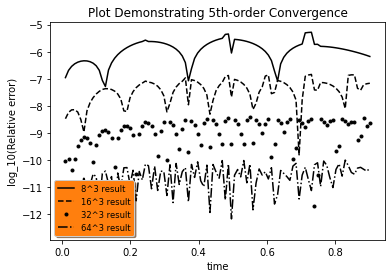

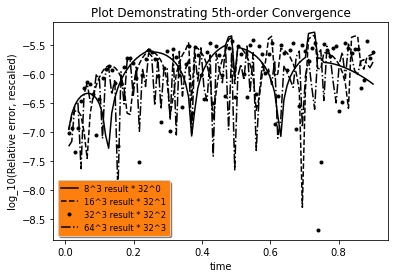

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpmath as mp
import csv

def file_reader(filename):
    with open(filename) as file:
        reader = csv.reader(file, delimiter=" ")
        data  = list(zip(*reader))
        # data is a tuple of strings. Tuples are immutable, and we need to perform math on
        #   the data, so here we convert tuple to lists of floats:
        data0 = []
        data1 = []
        for i in range(len(data[0])):
            data0.append(float(data[0][i]))
            data1.append(float(data[1][i]))
        return data0,data1

def plot_interp_data_convergence_tests(fileprefix="out"):
    position                 = []
    log10_rel_error          = []
    log10_rel_error_rescaled = []
    for i in [8,16,32,64]:
        position_i,rel_error_i = file_reader(os.path.join(Ccodesrootdir,fileprefix+str(i)+'.txt'))
        position.append(position_i)

        two_exponent = mp.log(float(i))/mp.log(float(2.0))
        log10_rel_error_i          = []
        log10_rel_error_rescaled_i = []
        for j in range(len(rel_error_i)):
            log10_rel_error_i.         append(mp.log10(rel_error_i[j]))
            log10_rel_error_rescaled_i.append(mp.log10(rel_error_i[j] * 32**(two_exponent-3.0)))
        log10_rel_error.         append(log10_rel_error_i)
        log10_rel_error_rescaled.append(log10_rel_error_rescaled_i)

    # https://matplotlib.org/gallery/text_labels_and_annotations/legend.html#sphx-glr-gallery-text-labels-and-annotations-legend-py
    fig, ax = plt.subplots()

    plt.title("Plot Demonstrating 5th-order Convergence")
    plt.xlabel("time")
    plt.ylabel("log_10(Relative error)")

    idx = 0
    plotstyle = ['k-','k--','k.','k-.']
    for i in [8,16,32,64]:
        two_exponent = mp.log(float(i))/mp.log(float(2.0))
        ax.plot(position[idx], log10_rel_error[idx], plotstyle[idx], label=str(i)+'^3 result')
        idx += 1
    legend = ax.legend(loc='lower left', shadow=True, fontsize='small')
    legend.get_frame().set_facecolor('C1')
    plt.show()

    fig, ax = plt.subplots()

    plt.title("Plot Demonstrating 5th-order Convergence")
    plt.xlabel("time")
    plt.ylabel("log_10(Relative error, rescaled)")
    idx=0
    for i in [8,16,32,64]:
        two_exponent = mp.log(float(i))/mp.log(float(2.0))
        ax.plot(position[idx], log10_rel_error_rescaled[idx], plotstyle[idx], label=str(i)+'^3 result * 32^'+str(idx))
        idx += 1
    legend = ax.legend(loc='lower left', shadow=True, fontsize='small')
    legend.get_frame().set_facecolor('C1')
    plt.show()

plot_interp_data_convergence_tests(fileprefix="out")

Finally, I include below some old compiler flag optimization tests, with the aim of finding the most optimal (GCC) compiler flags for this function. Various command-line options have been added since these tests were put in place.

In [ ]:
# !gcc -DBOUNDS_CHECKING -ffast-math -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm

# Compiler flag optimization tests:
# !gcc -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm
# !taskset -c 0,1,2,3 ./interp 128 128 128 #> out128.txt
# !gcc -march=native -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm
# !taskset -c 0,1,2,3 ./interp 128 128 128 #> out128.txt
# !gcc -ffast-math -march=native -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm
# !taskset -c 0,1,2,3 ./interp 128 128 128 #> out128.txt
# !gcc -ffast-math -march=native -finline-functions -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm
# !taskset -c 0,1,2,3 ./interp 128 128 128 #> out128.txt
# !gcc -fpredictive-commoning -ffast-math -march=native -finline-functions -O2 -fopenmp -Wall interpolation/Lagrange_3D_polynomial_interpolation_Playground.c -o interp -lm
# !taskset -c 0,1,2,3 ./interp 128 128 128 #> out128.txt

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Interpolation_on_Uniform_Grids-3D.pdf](Tutorial-Start_to_Finish-Interpolation_on_Uniform_Grids-3D.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Interpolation_from_Uniform_Grid-3D")